In [340]:
import skimage
import skimage.filters
from pathlib import Path
import io3d
from matplotlib import pyplot as plt
import scipy
import exsu
from skimage.morphology import label
from scipy.ndimage.morphology import binary_closing, binary_erosion, binary_opening, binary_dilation
from skimage.color import label2rgb
from skimage.measure import regionprops
import pandas as pd

In [341]:
pth = io3d.joinp("medical/orig/cardio_blood_cells/TP1_a")

In [342]:
pth.exists()

True

# Segmentation processing step by step

In [343]:
# for fn in pth.glob("*.jpg"):
fn = list(pth.glob("*jpg"))[3]
    

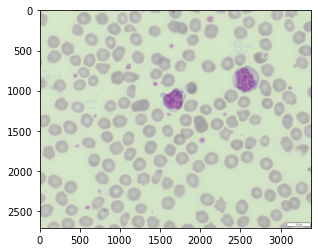

In [344]:
im = skimage.io.imread(fn)
plt.imshow(im)

In [345]:
report = exsu.Report("report", show=True)
debug = True

def show_if_debug(*args, debug=True, show_colorbar=False, **kwargs):
    if debug:
        plt.figure()
        plt.imshow(*args, **kwargs)
        if show_colorbar:
            plt.colorbar()

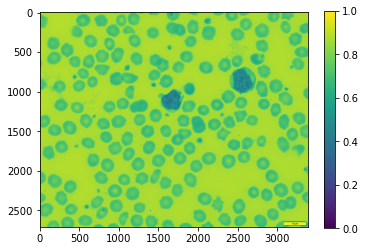

In [346]:
img = skimage.color.rgb2gray(im)
show_if_debug(img, debug=debug, show_colorbar=True)

In [347]:
threshold = skimage.filters.threshold_otsu(img[:])

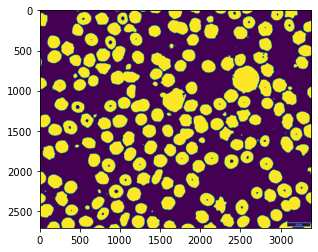

In [348]:
bim = img < threshold
show_if_debug(bim, debug=debug)

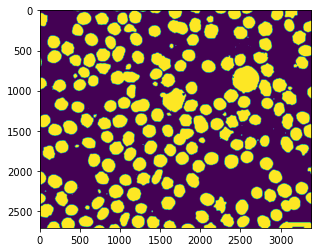

In [349]:
bim = scipy.ndimage.binary_fill_holes(bim)
show_if_debug(bim, debug=debug)

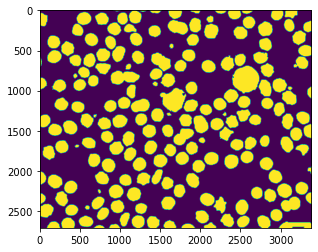

In [350]:
bim = skimage.morphology.remove_small_objects(bim, min_size=1000)
show_if_debug(bim, debug=debug)

In [351]:
# imlabel = label(bim, background=0)
# imrgb = label2rgb(imlabel, image=img)
# show_if_debug(imrgb)

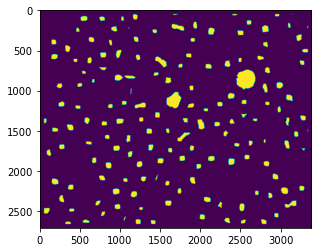

In [352]:
bimd = binary_erosion(bim,iterations=50)
bimd[-100:,-500:] = 0  # remove size tag
show_if_debug(bimd, debug=debug)

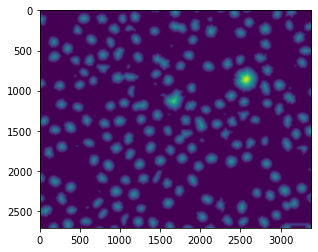

In [353]:
distance = scipy.ndimage.distance_transform_edt(bim)
show_if_debug(distance, debug=debug)


C:\Users\Jirik\Miniconda3\envs\lisa3qt5\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


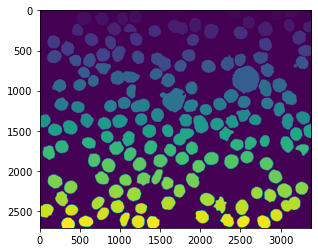

In [354]:
imlabel = skimage.morphology.watershed(-distance, markers=label(bimd), mask=bim)
show_if_debug(imlabel, debug=debug)

## Segmented cells

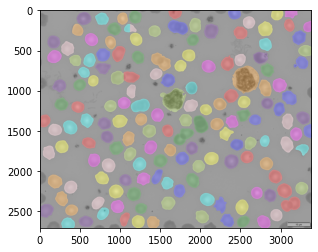

In [355]:
imrgb = label2rgb(imlabel, image=img, bg_label=0)
show_if_debug(imrgb)

# Cell shape description

In [356]:
from sklearn import datasets
import numpy as np
import sklearn.model_selection 

In [357]:
features = []
cls = []
i = 0
for props in regionprops(imlabel, intensity_image=img):
    feature = [
        props.area,
        (props.perimeter**2) / props.area,
        props.perimeter,
        props.max_intensity,
        props.mean_intensity,
        props.min_intensity
    ]
    features.append(feature)
    if props.area < 0.9e4:
        y = 1
        
    elif props.area > 2.5e4:
        y = 1
    else:

        # normal size
        if (props.perimeter**2) / props.area < 15.5:
            y = 2
        else:
            y = 3

    
    cls.append(y)
    i += 1


cls = np.array(cls)
counts = dict(zip(range(3), range(3)))
vals, co = np.unique(cls, return_counts=True)
counts.update(dict(zip(vals,co)))
vals, co

(array([1, 2, 3]), array([ 15, 110,  33], dtype=int64))

In [358]:
# ids = np.array(list(range(np.max(imlabel))))
# cls[ids==1]
imlabel_types = np.zeros_like(imlabel)
for i in range(1, np.max(imlabel)):
    imlabel_types[imlabel==i] = cls[i-1] + 1

In [359]:
features = np.array(features)

df = pd.DataFrame({
    "Area" : features[:,0],
    "Non-compactness": features[:,1],
    "Perimeter": features[:,2],
    "Max intensity": features[:,3],
    "Mean intensity": features[:,4],
    "Min intensity": features[:,5],
}
)
df

,Area,Non-compactness,Perimeter,Max intensity,Mean intensity,Min intensity
0,15155.0,16.173041,495.078210,0.790796,0.701080,0.522056
1,15950.0,15.200615,492.391919,0.832215,0.732741,0.650415
2,16568.0,14.790207,495.019336,0.813172,0.737527,0.695524
3,13237.0,18.824461,499.178716,0.790796,0.729019,0.680106
4,20439.0,14.704242,548.215295,0.790781,0.732440,0.651248
...,...,...,...,...,...,...
153,20979.0,15.027793,561.487373,0.790951,0.708709,0.670856
154,17693.0,14.936484,514.073160,0.790781,0.720377,0.670023
155,19258.0,15.198009,541.002092,0.790974,0.734493,0.690464
156,19111.0,15.034786,536.031529,0.790974,0.728048,0.684027


# Classification

* purple overlapps - not classified
* yellow - round blood cells
* magenta - rich-shape cells

Found 110 round cells (yellow) and 33 noncompcate cells (magenta). Igneored 15 objects (purple).


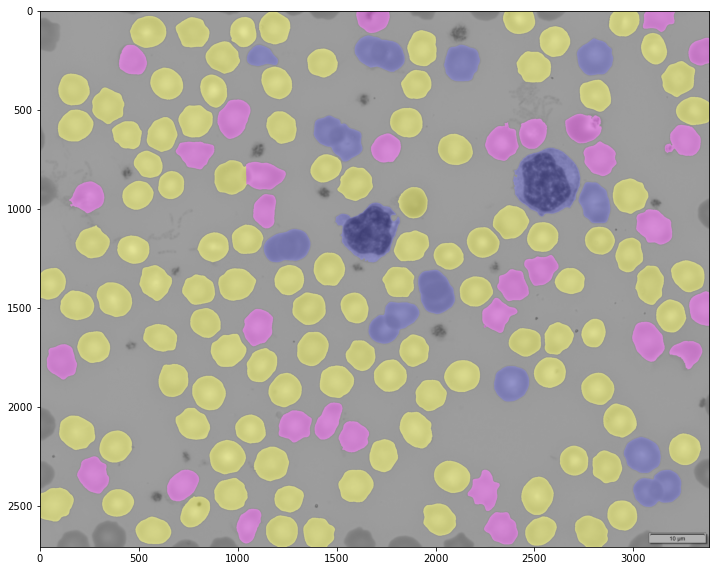

In [360]:
imrgb = label2rgb(imlabel_types, image=img, bg_label=0, colors=[[0,0,0.7],[1,1,0],[1,0,1]])
plt.figure(figsize=[12,10])
plt.imshow(imrgb)

print(f"Found {counts[2]} round cells (yellow) and {counts[3]} noncompcate cells (magenta). Igneored {counts[1]} objects (purple).")